In [2]:
import glob
import numpy as np
import tensorflow as tf

def npz_batch_generator(pattern, batch_size=512):
    files = sorted(glob.glob(pattern))
    X_buf, y_buf = [], []

    for fname in files:
        data = np.load(fname)
        X = data["X"]
        y = data["y"]

        for i in range(len(X)):
            X_buf.append(X[i])
            y_buf.append(y[i])

            if len(X_buf) == batch_size:
                yield np.array(X_buf, dtype=np.float32), np.array(y_buf, dtype=np.float32)
                X_buf, y_buf = [], []

def make_tf_dataset(pattern, batch_size=512):
    output_signature = (
        tf.TensorSpec(shape=(None, 768), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )

    ds = tf.data.Dataset.from_generator(
        lambda: npz_batch_generator(pattern, batch_size),
        output_signature=output_signature
    )

    ds = ds.repeat()  
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


2026-01-07 14:36:19.017207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767792979.033751 1169069 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767792979.040444 1169069 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767792979.136363 1169069 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767792979.136388 1169069 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767792979.136390 1169069 computation_placer.cc:177] computation placer alr

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

def build_dense_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(768,)))

    num_layers = hp.Int('num_layers', 1, 5)

    for i in range(num_layers):
        num_exp = hp.Int(f'num_exp_{i}', 4, 10)
        units = 2 ** num_exp

        activation = hp.Choice(f'activation_{i}', ['relu', 'tanh', 'elu'])

        model.add(layers.Dense(units=units, activation=activation))

        dropout_rate = hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1))

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model


In [4]:
import math


batch=4096
samples=48000000
steps_per_epoch = math.ceil((samples - (samples * 0.2)) / batch)  
validation_steps = math.ceil((samples * 0.2) / batch)

train_ds = make_tf_dataset("training/train_*.npz", batch_size=batch)
test_ds  = make_tf_dataset("training/test_*.npz",  batch_size=batch)
print(steps_per_epoch, validation_steps)

9375 2344


I0000 00:00:1767792984.410417 1169069 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9900 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6


In [5]:
import keras_tuner as kt

tuner = kt.BayesianOptimization(
    build_dense_model,
    objective="val_loss",
    max_trials=40,
    directory="bayesian_tuning",
    project_name="simple_dense_model"
)

tuner.search(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True
        )
    ]
)




Reloading Tuner from bayesian_tuning/simple_dense_model/tuner0.json


In [6]:
best_models = tuner.get_best_models(5)
best_hps = tuner.get_best_hyperparameters(5)

for i, (model, hp) in enumerate(zip(best_models, best_hps)):
    print(f"Model {i+1}:")
    print("Hiperparametry:")
    for param in hp.values:
        print(param, hp.get(param))
    num_params = model.count_params()  # liczba parametrów modelu
    print("Liczba parametrów:", num_params)
    print()

min_params = float('inf')
best_model_min_params = None
best_hp_min_params = None

for model, hp in zip(best_models, best_hps):
    num_params = model.count_params()
    if num_params < min_params:
        min_params = num_params
        best_model_min_params = model
        best_hp_min_params = hp

/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model 1:
Hiperparametry:
num_layers 3
num_exp_0 10
activation_0 elu
dropout_0 0.2
num_exp_1 10
activation_1 tanh
dropout_1 0.0
num_exp_2 4
activation_2 elu
dropout_2 0.1
num_exp_3 6
activation_3 relu
dropout_3 0.4
num_exp_4 4
activation_4 tanh
dropout_4 0.4
Liczba parametrów: 1853473

Model 2:
Hiperparametry:
num_layers 3
num_exp_0 10
activation_0 relu
dropout_0 0.4
num_exp_1 7
activation_1 tanh
dropout_1 0.2
num_exp_2 8
activation_2 elu
dropout_2 0.30000000000000004
num_exp_3 6
activation_3 relu
dropout_3 0.0
num_exp_4 10
activation_4 relu
dropout_4 0.4
Liczba parametrów: 951937

Model 3:
Hiperparametry:
num_layers 4
num_exp_0 10
activation_0 relu
dropout_0 0.4
num_exp_1 9
activation_1 tanh
dropout_1 0.4
num_exp_2 4
activation_2 relu
dropout_2 0.1
num_exp_3 9
activation_3 relu
dropout_3 0.0
num_exp_4 8
activation_4 elu
dropout_4 0.4
Liczba parametrów: 1329681

Model 4:
Hiperparametry:
num_layers 2
num_exp_0 10
activation_0 relu
dropout_0 0.4
num_exp_1 6
activation_1 tanh
dropout_1 0.3

In [11]:
import numpy as np
import tensorflow as tf

def model2bin(model, filename):
    with open(f"{filename}.bin", "wb") as f:
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                for w in layer.get_weights():
                    w.astype(np.float32).tofile(f)


def model2h(model, filename):
    with open(f"{filename}.h", "w") as f:
        f.write("// Auto-generated model weights\n")
        f.write("#pragma once\n\n")

        layer_idx = 0

        for layer in model.layers:
            if not isinstance(layer, tf.keras.layers.Dense):
                continue

            weights, biases = layer.get_weights()

            w = weights.astype(np.float32)
            b = biases.astype(np.float32)

            in_dim, out_dim = w.shape
            print(f"layer{layer_idx}: weights: {in_dim}, biases: {out_dim}")

            # --- weights ---
            f.write(f"static const float layer{layer_idx}w[{in_dim}][{out_dim}] = {{\n")
            for i in range(in_dim):
                row = ", ".join(f"{v:.8f}f" for v in w[i])
                f.write(f"    {{{row}}},\n")
            f.write("};\n\n")

            # --- biases ---
            f.write(f"static const float layer{layer_idx}b[{out_dim}] = {{\n    ")
            f.write(", ".join(f"{v:.8f}f" for v in b))
            f.write("\n};\n\n")

            layer_idx += 1


In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = build_dense_model(best_hp)
history = model.fit(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=500,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True
        )
    ]
)


Epoch 1/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 222s 23ms/step - loss: 18030.1953 - mae: 80.2622 - val_loss: 11346.8955 - val_mae: 60.9992
Epoch 2/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 217s 23ms/step - loss: 11425.4580 - mae: 64.2977 - val_loss: 9194.3896 - val_mae: 53.5717
Epoch 3/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 219s 23ms/step - loss: 9890.9268 - mae: 59.8086 - val_loss: 8393.1602 - val_mae: 51.7577
Epoch 4/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 218s 23ms/step - loss: 9189.3623 - mae: 57.5919 - val_loss: 8058.3047 - val_mae: 49.1531
Epoch 5/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 218s 23ms/step - loss: 8769.8770 - mae: 56.1959 - val_loss: 7831.9624 - val_mae: 48.8603
Epoch 6/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 216s 23ms/step - loss: 8457.3936 - mae: 55.1611 - val_loss: 7685.2041 - val_mae: 47.0521
Epoch 7/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 216s 23ms/step - loss: 8224.8887 - mae: 54.3857 - val_loss: 7578.5894 - val_mae: 46.5581
Epoch 8/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 213s 23ms/step - loss: 8039.15

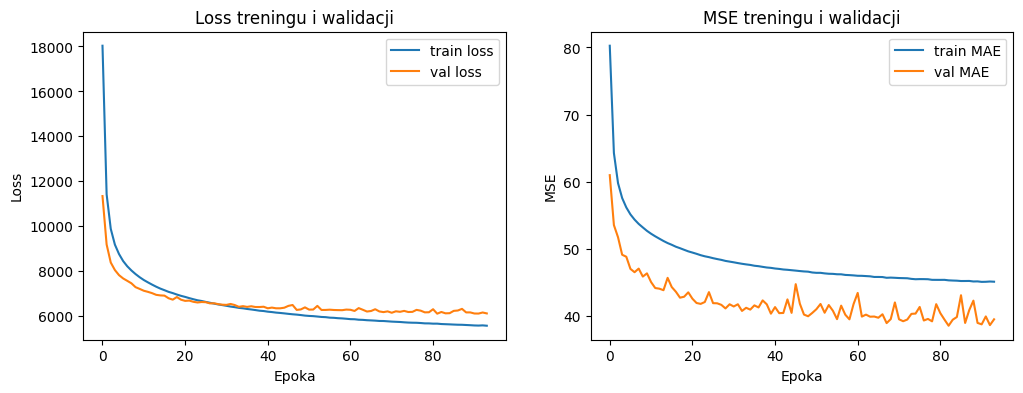

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.title('Loss treningu i walidacji')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.xlabel('Epoka')
plt.ylabel('MSE')
plt.title('MSE treningu i walidacji')
plt.legend()

plt.show()

In [ ]:
#drugi model
train_ds = make_tf_dataset("training_Positional/train_*.npz", batch_size=batch)
test_ds  = make_tf_dataset("training_Positional/test_*.npz",  batch_size=batch)

best_hp = tuner.get_best_hyperparameters(0)[0]
model2 = build_dense_model(best_hp)
history = model2.fit(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=500,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True
        )
    ]
)


Epoch 1/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 217s 23ms/step - loss: 17369.0234 - mae: 79.6351 - val_loss: 10689.2725 - val_mae: 59.1246
Epoch 2/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 211s 22ms/step - loss: 11057.4854 - mae: 64.3180 - val_loss: 8845.5645 - val_mae: 55.6070
Epoch 3/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 212s 23ms/step - loss: 9787.3037 - mae: 60.6709 - val_loss: 8450.9834 - val_mae: 52.7052
Epoch 4/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 215s 23ms/step - loss: 9163.2451 - mae: 58.8329 - val_loss: 8002.7646 - val_mae: 50.6329
Epoch 5/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 211s 23ms/step - loss: 8773.7461 - mae: 57.6449 - val_loss: 7723.5728 - val_mae: 49.8467
Epoch 6/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 212s 23ms/step - loss: 8489.1387 - mae: 56.7696 - val_loss: 7595.0264 - val_mae: 49.0635
Epoch 7/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 210s 22ms/step - loss: 8263.6621 - mae: 56.0493 - val_loss: 7507.5640 - val_mae: 48.4655
Epoch 8/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 211s 23ms/step - loss: 8081.64

NameError: name 'history' is not defined

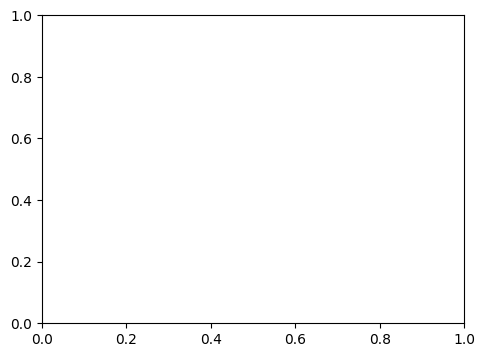

In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.title('Loss treningu i walidacji')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.xlabel('Epoka')
plt.ylabel('MSE')
plt.title('MSE treningu i walidacji')
plt.legend()

plt.show()

In [15]:

model.save('agressive.keras')
model2.save('positional.keras')

In [19]:
model2h(model, 'agressiveWeights')
model2h(model2, 'positionalWeights')

In [12]:
from tensorflow.keras.models import load_model
model3 = load_model('models/agressive_7.keras')
model2h(model3, 'agressiveMCTSv5Weights.h')

layer0: weights: 768, biases: 1024
layer1: weights: 1024, biases: 1024
layer2: weights: 1024, biases: 16
layer3: weights: 16, biases: 1
